In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from subprocess import check_output
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/mushrooms-classification-common-genuss-images/Mushrooms/Entoloma/126_-P40YY9dxnU.jpg
/kaggle/input/mushrooms-classification-common-genuss-images/Mushrooms/Entoloma/092_C-d5aHykeOY.jpg
/kaggle/input/mushrooms-classification-common-genuss-images/Mushrooms/Entoloma/033_yJBfhGv9URU.jpg
/kaggle/input/mushrooms-classification-common-genuss-images/Mushrooms/Entoloma/154_HDT_he4bSpA.jpg
/kaggle/input/mushrooms-classification-common-genuss-images/Mushrooms/Entoloma/159_gzyo4cu2SF0.jpg
/kaggle/input/mushrooms-classification-common-genuss-images/Mushrooms/Entoloma/359_bFyWPqjfpXM.jpg
/kaggle/input/mushrooms-classification-common-genuss-images/Mushrooms/Entoloma/012_R7t5KGL2a2k.jpg
/kaggle/input/mushrooms-classification-common-genuss-images/Mushrooms/Entoloma/228_eHNGN7ANh4o.jpg
/kaggle/input/mushrooms-classification-common-genuss-images/Mushrooms/Entoloma/004_HmcJQ_lPE3g.jpg
/kaggle/input/mushrooms-classification-common-genuss-images/Mushrooms/Entoloma/198_fmlPWLGNaaw.jpg
/kaggle/in

In [2]:
import os
import shutil
import pandas as pd

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import preprocess_input, ResNet50
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [4]:
# To fix "Image File is truncated" error during training
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [5]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

In [6]:
plt.rcParams['figure.figsize'] = 12, 8
plt.rcParams.update({'font.size': 12})

## 1.Loading and processing data

In [7]:
# Path to the folder with 9 classes of images:
data_path = '/kaggle/input/mushrooms-classification-common-genuss-images/Mushrooms'
# Temporary folders for training, validation and test images:
os.mkdir('/kaggle/temp')
os.chdir('/kaggle/temp')
os.mkdir('train')
os.mkdir('valid')
os.mkdir('test')
os.chdir('/kaggle/working')

In [8]:
# Split images (75%/15%/10%) and save to temporary folders:
for subfolder in os.listdir(data_path):

    # Making a list of all files in current subfolder:
    original_path = f'{data_path}/{subfolder}'
    original_data = os.listdir(original_path)

    # Number of samples in each group:
    n_samples = len(original_data)
    train_samples = int(n_samples * 0.75)
    valid_samples = int(n_samples * 0.9)
        
    train_path = f'/kaggle/temp/train/{subfolder}'
    valid_path = f'/kaggle/temp/valid/{subfolder}'
    test_path = f'/kaggle/temp/test/{subfolder}'
    
    # New class subfolder for training:
    os.chdir('/kaggle/temp/train')
    os.mkdir(subfolder)
    
    # Training images:
    for image in range(train_samples):
        original_file = f'{original_path}/{original_data[image]}'
        new_file = f'{train_path}/{original_data[image]}'
        shutil.copyfile(original_file, new_file)
    
    # New class subfolder for validation:
    os.chdir('/kaggle/temp/valid')
    os.mkdir(subfolder)
    
    # Validation images:
    for image in range(train_samples, valid_samples):
        original_file = f'{original_path}/{original_data[image]}'
        new_file = f'{valid_path}/{original_data[image]}'
        shutil.copyfile(original_file, new_file)
    
    # New class subfolder for testing:
    os.chdir('/kaggle/temp/test')
    os.mkdir(subfolder)
    
    # Test images:
    for image in range(valid_samples, n_samples):
        original_file = f'{original_path}/{original_data[image]}'
        new_file = f'{test_path}/{original_data[image]}'
        shutil.copyfile(original_file, new_file)

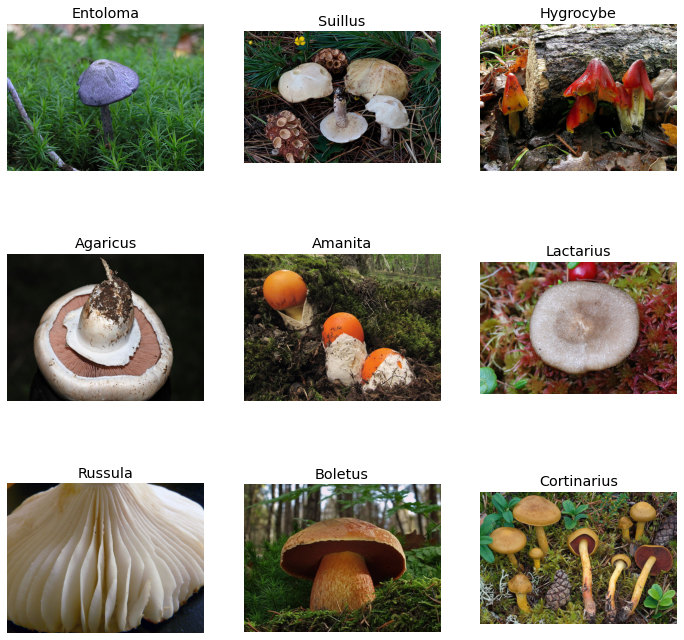

In [9]:
# Displaying examples from each class
nrows = 3
ncols = 3

pos = 0

for subfolder in os.listdir(data_path):
    
    image_file = os.listdir(os.path.join(data_path, subfolder))[0]
    
    fig = plt.gcf()
    fig.set_size_inches(ncols * 4, nrows * 4)

    pos += 1
    sp = plt.subplot(nrows, ncols, pos)

    cur_image = mpimg.imread(os.path.join(data_path, subfolder, image_file))
    plt.imshow(cur_image)
    plt.title(subfolder)
    plt.axis('Off')

In [10]:
# Prepare data for ML model:
train_generator = ImageDataGenerator(preprocessing_function=preprocess_input)\
                    .flow_from_directory(directory='/kaggle/temp/train',
                                         target_size=(224, 224),
                                         class_mode='categorical',
                                         batch_size=100)
valid_generator = ImageDataGenerator(preprocessing_function=preprocess_input)\
                    .flow_from_directory(directory='/kaggle/temp/valid',
                                         target_size=(224, 224),
                                         class_mode='categorical',
                                         batch_size=100)
test_generator = ImageDataGenerator(preprocessing_function=preprocess_input)\
                    .flow_from_directory(directory='/kaggle/temp/test',
                                         target_size=(224, 224),
                                         class_mode='categorical',
                                         batch_size=100)

Found 5033 images belonging to 9 classes.
Found 1005 images belonging to 9 classes.
Found 676 images belonging to 9 classes.


## 2.Creating a model

In [11]:
# Load ResNet50 model:
resnet_model = ResNet50(weights="imagenet")
resnet_model.summary()

102973440/102967424 [==============================] - 1s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
________________________

In [12]:
# Extract all layers up to the final average pooling layer:
last_layer = resnet_model.get_layer("avg_pool")
resnet_layers = Model(inputs=resnet_model.inputs, outputs=last_layer.output)

In [13]:
# Construct a new model with the final dense layer for 9 classes:
new_model = Sequential()
new_model.add(resnet_layers)
new_model.add(Dense(9, activation="softmax"))

In [14]:
# Make all the layers from the original ResNet model untrainable:
new_model.layers[0].trainable=False

In [15]:
# Metrics and optimizer:
new_model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [16]:
# Check the structure of new model:
new_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
functional_1 (Functional)    (None, 2048)              23587712  
_________________________________________________________________
dense (Dense)                (None, 9)                 18441     
Total params: 23,606,153
Trainable params: 18,441
Non-trainable params: 23,587,712
_________________________________________________________________


In [17]:
# Introduce callbacks to be exercised during training:
early_stop = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1,
                              mode='max', cooldown=2, patience=2, min_lr=0)

In [18]:
# Train new model:
history = new_model.fit(train_generator, validation_data=valid_generator,
                        epochs=100, verbose=2, callbacks=[reduce_lr, early_stop])

Epoch 1/100
51/51 - 61s - loss: 1.4479 - accuracy: 0.5045 - val_loss: 1.0996 - val_accuracy: 0.6239
Epoch 2/100
51/51 - 58s - loss: 0.8626 - accuracy: 0.7123 - val_loss: 0.9203 - val_accuracy: 0.7005
Epoch 3/100
51/51 - 58s - loss: 0.7079 - accuracy: 0.7659 - val_loss: 0.8401 - val_accuracy: 0.7194
Epoch 4/100
51/51 - 59s - loss: 0.6082 - accuracy: 0.7981 - val_loss: 0.8158 - val_accuracy: 0.7164
Epoch 5/100
51/51 - 59s - loss: 0.5493 - accuracy: 0.8190 - val_loss: 0.7829 - val_accuracy: 0.7353
Epoch 6/100
51/51 - 59s - loss: 0.4949 - accuracy: 0.8399 - val_loss: 0.7635 - val_accuracy: 0.7423
Epoch 7/100
51/51 - 58s - loss: 0.4485 - accuracy: 0.8556 - val_loss: 0.7311 - val_accuracy: 0.7522
Epoch 8/100
51/51 - 59s - loss: 0.4192 - accuracy: 0.8665 - val_loss: 0.7307 - val_accuracy: 0.7592
Epoch 9/100
51/51 - 59s - loss: 0.3960 - accuracy: 0.8746 - val_loss: 0.7226 - val_accuracy: 0.7542
Epoch 10/100
51/51 - 59s - loss: 0.3668 - accuracy: 0.8899 - val_loss: 0.7117 - val_accuracy: 0.7582

## 3.Display Results

In [19]:
loss, accuracy = new_model.evaluate(test_generator, verbose=2)
print(f'Model performance on test images:\nAccuracy = {accuracy}\nLoss = {loss}')

7/7 - 6s - loss: 0.6113 - accuracy: 0.8077
Model performance on test images:
Accuracy = 0.807692289352417
Loss = 0.6113283634185791


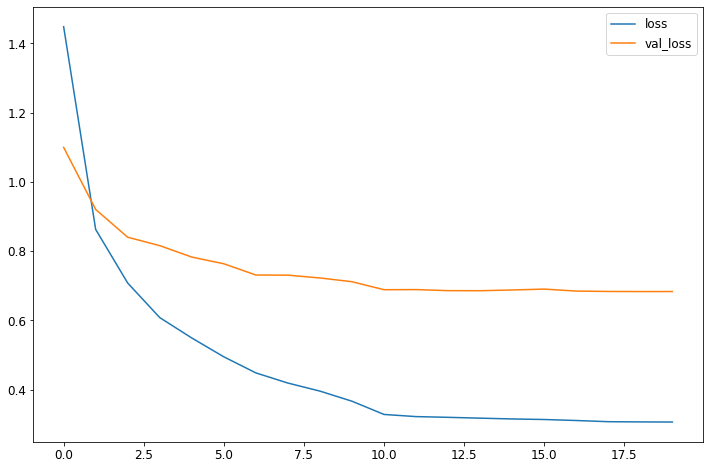

In [20]:
# Loss during training:
history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot();

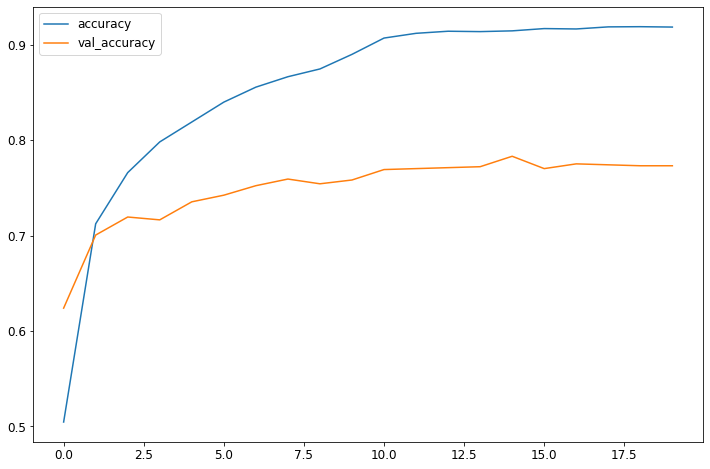

In [21]:
# Accuracy during training:
history_frame.loc[:, ['accuracy', 'val_accuracy']].plot();

In [22]:
print("Accuracy on test set: ", accuracy)

Accuracy on test set:  0.807692289352417
